# Lab 4 Report

In [1]:
from pyspark import SparkContext, RDD, sql
from pyspark.mllib.regression import LabeledPoint
from pyspark.mllib.tree import DecisionTree, DecisionTreeModel
from pyspark.mllib.util import MLUtils
import pandas as pd

In [2]:
sc = SparkContext(appName="DecisionTreeClassification")
sc.setLogLevel("ERROR")

data = pd.read_table("../dataset/arcene_train.data", sep=" ", header=None)
del data[10000]
target = pd.read_table("../dataset/arcene_train.labels", sep=" ", header=None).replace(to_replace="-1", value="0")
labeled_point_array = []
df_arrays = data.values
for index, row in data.iterrows():
        lp = LabeledPoint(target[0][index], df_arrays[index])
        labeled_point_array.append(lp)
rdd = sc.parallelize(labeled_point_array)
(trainingData, validationData) = rdd.randomSplit([0.7, 0.3])

In [3]:
def testModel(model, validationData):
    predictions = model.predict(validationData.map(lambda x: x.features))
    labelsAndPredictions = validationData.map(lambda lp: lp.label).zip(predictions)
    testErr = labelsAndPredictions.filter(lambda (v, p): v != p).count() / float(validationData.count())
    testAccuracy = 1-testErr
    print('Validation Error = ' + str(testErr))
    print('Learned classification tree model:')
    print(model.toDebugString())
    return testAccuracy

In [4]:
models = list()
accuracies = list()
impurities = ['gini', 'entropy']
mBins = [16, 32, 48, 64, 80, 96, 112, 128, 144, 160]
mDepth = [1, 2, 3, 4, 5]

## Decision Tree

In [5]:
for i in impurities:
    models.append(DecisionTree.trainClassifier(trainingData, numClasses=2, categoricalFeaturesInfo={}, impurity=i, maxDepth=5, maxBins=32))
    accuracies.append(testModel(models[len(models)-1], validationData))

Validation Error = 0.25
Learned classification tree model:
DecisionTreeModel classifier of depth 4 with 13 nodes
  If (feature 8501 <= 42.0)
   If (feature 1183 <= 46.0)
    If (feature 79 <= 0.0)
     If (feature 919 <= 102.0)
      Predict: 1.0
     Else (feature 919 > 102.0)
      Predict: 0.0
    Else (feature 79 > 0.0)
     If (feature 0 <= 24.0)
      Predict: 0.0
     Else (feature 0 > 24.0)
      Predict: 1.0
   Else (feature 1183 > 46.0)
    Predict: 0.0
  Else (feature 8501 > 42.0)
   If (feature 4 <= 86.0)
    Predict: 0.0
   Else (feature 4 > 86.0)
    Predict: 1.0

Validation Error = 0.35
Learned classification tree model:
DecisionTreeModel classifier of depth 5 with 13 nodes
  If (feature 1183 <= 46.0)
   If (feature 733 <= 3.0)
    If (feature 3318 <= 28.0)
     If (feature 6162 <= 52.0)
      If (feature 282 <= 25.0)
       Predict: 1.0
      Else (feature 282 > 25.0)
       Predict: 0.0
     Else (feature 6162 > 52.0)
      If (feature 3 <= 45.0)
       Predict: 1.0
  

The validation set accuracy was 75% for Gini and 65% for Entropy

In [6]:
for m in mBins:
    models.append(DecisionTree.trainClassifier(trainingData, numClasses=2, categoricalFeaturesInfo={}, impurity='gini', maxDepth=5, maxBins=m))
    accuracies.append(testModel(models[len(models)-1], validationData))

Validation Error = 0.2
Learned classification tree model:
DecisionTreeModel classifier of depth 4 with 13 nodes
  If (feature 8501 <= 42.0)
   If (feature 1183 <= 46.0)
    If (feature 79 <= 0.0)
     If (feature 919 <= 102.0)
      Predict: 1.0
     Else (feature 919 > 102.0)
      Predict: 0.0
    Else (feature 79 > 0.0)
     If (feature 0 <= 24.0)
      Predict: 0.0
     Else (feature 0 > 24.0)
      Predict: 1.0
   Else (feature 1183 > 46.0)
    Predict: 0.0
  Else (feature 8501 > 42.0)
   If (feature 26 <= 70.0)
    Predict: 0.0
   Else (feature 26 > 70.0)
    Predict: 1.0

Validation Error = 0.25
Learned classification tree model:
DecisionTreeModel classifier of depth 4 with 13 nodes
  If (feature 8501 <= 42.0)
   If (feature 1183 <= 46.0)
    If (feature 79 <= 0.0)
     If (feature 919 <= 102.0)
      Predict: 1.0
     Else (feature 919 > 102.0)
      Predict: 0.0
    Else (feature 79 > 0.0)
     If (feature 0 <= 24.0)
      Predict: 0.0
     Else (feature 0 > 24.0)
      Predic

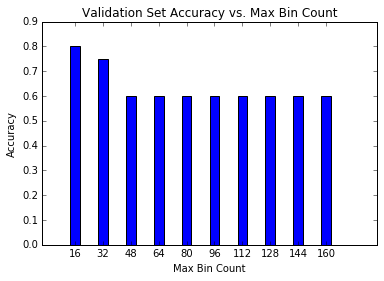

In [7]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

width = 0.35
ind = np.arange(10)+1
fig, ax = plt.subplots()
bar = ax.bar(ind, accuracies[2:12], width, color="blue")

ax.set_title('Validation Set Accuracy vs. Max Bin Count')
ax.set_ylabel('Accuracy')
ax.set_xlabel('Max Bin Count')
ax.set_xticks(ind + width/2)
ax.set_xticklabels(mBins)

fig = plt.gcf()

In [9]:
for m in mDepth:
    models.append(DecisionTree.trainClassifier(trainingData, numClasses=2, categoricalFeaturesInfo={}, impurity='gini', maxDepth=m, maxBins=16))
    accuracies.append(testModel(models[len(models)-1], validationData))

Validation Error = 0.25
Learned classification tree model:
DecisionTreeModel classifier of depth 1 with 3 nodes
  If (feature 8501 <= 42.0)
   Predict: 1.0
  Else (feature 8501 > 42.0)
   Predict: 0.0

Validation Error = 0.15
Learned classification tree model:
DecisionTreeModel classifier of depth 2 with 7 nodes
  If (feature 8501 <= 42.0)
   If (feature 1183 <= 46.0)
    Predict: 1.0
   Else (feature 1183 > 46.0)
    Predict: 0.0
  Else (feature 8501 > 42.0)
   If (feature 26 <= 70.0)
    Predict: 0.0
   Else (feature 26 > 70.0)
    Predict: 1.0

Validation Error = 0.25
Learned classification tree model:
DecisionTreeModel classifier of depth 3 with 9 nodes
  If (feature 8501 <= 42.0)
   If (feature 1183 <= 46.0)
    If (feature 79 <= 0.0)
     Predict: 1.0
    Else (feature 79 > 0.0)
     Predict: 0.0
   Else (feature 1183 > 46.0)
    Predict: 0.0
  Else (feature 8501 > 42.0)
   If (feature 26 <= 70.0)
    Predict: 0.0
   Else (feature 26 > 70.0)
    Predict: 1.0

Validation Error = 0

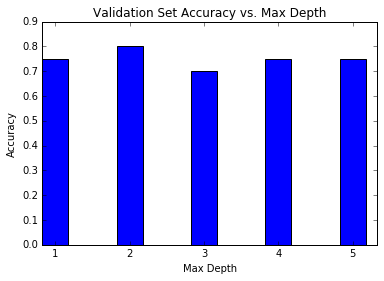

In [10]:
width = 0.35
ind = np.arange(5)+1
fig, ax = plt.subplots()
bar = ax.bar(ind, accuracies[12:17], width, color="blue")

ax.set_title('Validation Set Accuracy vs. Max Depth')
ax.set_ylabel('Accuracy')
ax.set_xlabel('Max Depth')
ax.set_xticks(ind + width/2)
ax.set_xticklabels(mDepth)

fig = plt.gcf()

In [49]:
print "With the fiunal parameters (below) the accuracy attained on the validation set was: %s%% " % (max(accuracies)*100)

With the fiunal parameters (below) the accuracy attained on the validation set was: 85.0% 


In [11]:
X_test = pd.read_table("../dataset/arcene_test.data", sep=" ", header=None)
del X_test[10000]
y_test = pd.read_table("../dataset/arcene_test.labels", sep=" ", header=None).replace(to_replace="-1", value="0")
labeled_test = []
test_arr = X_test.values
for index, row in X_test.iterrows():
        lp = LabeledPoint(y_test[0][index], test_arr[index])
        labeled_test.append(lp)
rdd_test = sc.parallelize(labeled_test)

In [50]:
finalModel = DecisionTree.trainClassifier(rdd, numClasses=2, categoricalFeaturesInfo={}, impurity='gini', maxDepth=2, maxBins=16)
finalAccuracy = testModel(finalModel, rdd_test)
print "Accuracy Trained on the Entire Training Set and Run on the Test Set: %s%%" % (finalAccuracy*100)

Validation Error = 0.43
Learned classification tree model:
DecisionTreeModel classifier of depth 2 with 7 nodes
  If (feature 8501 <= 42.0)
   If (feature 1183 <= 46.0)
    Predict: 1.0
   Else (feature 1183 > 46.0)
    Predict: 0.0
  Else (feature 8501 > 42.0)
   If (feature 29 <= 40.0)
    Predict: 1.0
   Else (feature 29 > 40.0)
    Predict: 0.0

Accuracy Trained on the Entire Training Set and Run on the Test Set: 57.0%


The final parameters were:

impurity: "gini"

maxBins: 16

maxDepth: 5

# Random Forests

In [18]:
from pyspark.mllib.tree import RandomForest
from time import time

t0 = time()
model = RandomForest.trainClassifier(trainingData, numClasses=2, categoricalFeaturesInfo={},
                                     numTrees=3, featureSubsetStrategy="auto",
                                     impurity='gini', maxDepth=2, maxBins=16)
t1 = time() - t0
print "Training Time: %s" % (t1)
predictions = model.predict(validationData.map(lambda x: x.features))
labelsAndPredictions = validationData.map(lambda lp: lp.label).zip(predictions)
testErr = labelsAndPredictions.filter(lambda (v, p): v != p).count() / float(validationData.count())
testAccuracy = 1-testErr
print('Test Accuracy = ' + str(float(testAccuracy*100)) + "%")

Training Time: 3.6362888813
Test Accuracy = 75.0%


In [24]:
bestAccuracy = testAccuracy
def testForest(n, validationData):
    t0 = time()
    model = RandomForest.trainClassifier(trainingData, numClasses=2, categoricalFeaturesInfo={},
                                     numTrees=n, featureSubsetStrategy="auto",
                                     impurity='gini', maxDepth=2, maxBins=16)
    t1 = time() - t0
    predictions = model.predict(validationData.map(lambda x: x.features))
    labelsAndPredictions = validationData.map(lambda lp: lp.label).zip(predictions)
    testErr = labelsAndPredictions.filter(lambda (v, p): v != p).count() / float(validationData.count())
    testAccuracy = 1-testErr
    return testAccuracy, t1

In [25]:
treeCount = list()
accuracies2 = list()
timeCount = list()
numTrees = 4
increasing = True
t3 = time()
t4 = time() - t3
while(t1<500):
    acc, t = testForest(numTrees, validationData)
    treeCount.append(numTrees)
    accuracies2.append(acc)
    timeCount.append(t)
    print "Number of Trees: %s" % (numTrees)
    print "Training Time: %s" % (t)
    print "Test Accuracy: %s%%" % (acc*100)
    if (t > 1200): increasing=False
    else: 
        bestAccuracy = acc
        numTrees += 1
    t4 = time() - t3
    print t4

Number of Trees: 4
Training Time: 3.61160778999
Test Accuracy: 55.0%
4.06995606422
Number of Trees: 5
Training Time: 3.29995298386
Test Accuracy: 65.0%
7.6389529705
Number of Trees: 6
Training Time: 3.60229110718
Test Accuracy: 65.0%
11.4915361404
Number of Trees: 7
Training Time: 3.51107811928
Test Accuracy: 65.0%
15.2554290295
Number of Trees: 8
Training Time: 3.58144593239
Test Accuracy: 85.0%
19.1383271217
Number of Trees: 9
Training Time: 3.92516708374
Test Accuracy: 55.0%
23.426099062
Number of Trees: 10
Training Time: 3.82307314873
Test Accuracy: 80.0%
27.6120579243
Number of Trees: 11
Training Time: 3.40725898743
Test Accuracy: 70.0%
31.2961461544
Number of Trees: 12
Training Time: 3.37014198303
Test Accuracy: 80.0%
34.9197220802
Number of Trees: 13
Training Time: 3.64970088005
Test Accuracy: 70.0%
39.075510025
Number of Trees: 14
Training Time: 3.59202384949
Test Accuracy: 70.0%
42.944922924
Number of Trees: 15
Training Time: 3.39911794662
Test Accuracy: 65.0%
46.5856180191
Nu

KeyboardInterrupt: 

In [33]:
i = accuracies2.index(max(accuracies2))
acc2 = accuracies2[:(i+2)]
T = treeCount[i]

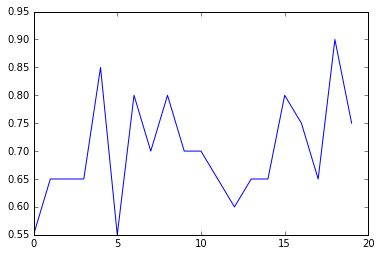

In [39]:
acc2[i]
x = treeCount[:(i+2)]
y = acc2

fig = plt.plot(y)
fig = plt.gcf()

With 22 trees the validation set accuracy reached 90%

In [41]:
from multiprocessing.pool import ThreadPool

def timedForestTest(validationData):
    t0 = time()
    model = RandomForest.trainClassifier(trainingData, numClasses=2, categoricalFeaturesInfo={},
                                     numTrees=n, featureSubsetStrategy="auto",
                                     impurity='gini', maxDepth=4, maxBins=32)
    t1 = time() - t0
    predictions = model.predict(validationData.map(lambda x: x.features))
    labelsAndPredictions = validationData.map(lambda lp: lp.label).zip(predictions)
    testErr = labelsAndPredictions.filter(lambda (v, p): v != p).count() / float(validationData.count())
    testAccuracy = 1-testErr
    return t1

p_list = [1,2,3,4]
training_times = list()
for p in p_list:
    tpool = ThreadPool(processes=p)
    training_times.append(tpool.map(timedForestTest))

TypeError: map() takes at least 3 arguments (2 given)

In [42]:
finalModel = RandomForest.trainClassifier(trainingData, numClasses=2, categoricalFeaturesInfo={},
                                     numTrees=22, featureSubsetStrategy="auto",
                                     impurity='gini', maxDepth=2, maxBins=16)
finalAccuracy = testModel(finalModel, rdd_test)
print "Accuracy Trained on the Entire Training Set and Run on the Test Set: %s" % (finalAccuracy)

Validation Error = 0.25
Learned classification tree model:
TreeEnsembleModel classifier with 22 trees

  Tree 0:
    If (feature 9608 <= 2.0)
     If (feature 1288 <= 45.0)
      Predict: 0.0
     Else (feature 1288 > 45.0)
      Predict: 1.0
    Else (feature 9608 > 2.0)
     If (feature 700 <= 387.0)
      Predict: 0.0
     Else (feature 700 > 387.0)
      Predict: 1.0
  Tree 1:
    If (feature 3398 <= 20.0)
     If (feature 4413 <= 18.0)
      Predict: 1.0
     Else (feature 4413 > 18.0)
      Predict: 0.0
    Else (feature 3398 > 20.0)
     If (feature 7037 <= 502.0)
      Predict: 0.0
     Else (feature 7037 > 502.0)
      Predict: 1.0
  Tree 2:
    If (feature 4818 <= 92.0)
     If (feature 1183 <= 46.0)
      Predict: 1.0
     Else (feature 1183 > 46.0)
      Predict: 0.0
    Else (feature 4818 > 92.0)
     Predict: 0.0
  Tree 3:
    If (feature 9274 <= 43.0)
     If (feature 3584 <= 44.0)
      Predict: 1.0
     Else (feature 3584 > 44.0)
      Predict: 0.0
    Else (feature 92

With the final parameters of...

impurity: "gini"

maxBins: 16

maxDepth: 5

numTrees: 22

... the accuracy reached on the test set was 75%